# Dog Breed Classification Using Machine Learning

## Georgia, Helina and Madison

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16\



2024-12-13 04:30:10.742861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-13 04:30:10.874191: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 04:30:10.880663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/n

# Importing and Visualizing Data
Using kagglehub to get the dataset. Loads it into a cache, meaning that the it's not the entire set being loaded onto the device. 

In [2]:
# !pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mulugetah/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [3]:
# Loading data into the memory is not efficient since it doesn't have enough memory for that much data
# Load filenames into dataframe instead

images = []

labels = []

label_count = 0

images_path = path + r"/images/Images/"

for label in os.listdir(images_path):
    label_path = images_path + label + "/"
    label_count += 1
    for file in os.listdir(label_path):
        images.append(label_path + file)
        labels.append(label.split('-')[1])

df = pd.DataFrame({"image_path" : images, "label": labels})


# For experimentation purposes, reducing the number of classes
df = df[df['label'].isin(df['label'].unique()[:4])]


In [4]:
df.value_counts('label')


label
Maltese_dog         252
Japanese_spaniel    185
Chihuahua           152
Pekinese            149
Name: count, dtype: int64

In [5]:
df.shape

(738, 2)

In [6]:
X_train, X_temp = train_test_split(df, test_size=0.2, stratify=df["label"], random_state = 42)

label_test_val = X_temp['label']

# 10%.   10%
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape) # Currently not using test data
print('The shape of validation data',X_val.shape)

The shape of train data (590, 2)
The shape of test data (74, 2)
The shape of validation data (74, 2)


In [7]:
# parameters
image_size = 255 # Size of the image
image_channel = 3 # Colour scale (RGB)
bat_size = 64 # Number of files/images processed at once

In [8]:
# Applying image data gernerator to train and test data
datagen = ImageDataGenerator(
            validation_split=0.2,
            rescale=1./255, # to bring the image range from 0..255 to 0..1
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.01, # randomly zoom image 
            width_shift_range=0.01,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.01,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,
            samplewise_center = True,
            #shear_range = 0.01,
            samplewise_std_normalization = True,
            fill_mode = "nearest")

train_generator = datagen.flow_from_dataframe(X_train,
                                                    x_col= 'image_path',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode="categorical",
                                                   )
val_generator = datagen.flow_from_dataframe(X_val, 
                                                 x_col= 'image_path',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode="categorical",
                                                )

test_generator = datagen.flow_from_dataframe(X_test, 
                                                  x_col= 'image_path',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                 )

Found 590 validated image filenames belonging to 4 classes.
Found 74 validated image filenames belonging to 4 classes.
Found 74 validated image filenames belonging to 4 classes.


In [9]:
# use the data generator to get the number of classes
num_classes = len(test_generator.class_indices)

Displaying some images in the dataset.

In [10]:
plt.figure(figsize=(10,8))


for i in range(1,5):
  plt.subplot(1, 4, i)
  batch = next(test_generator)
  image_ = batch[0][0]
  plt.imshow(image_)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5894529..1.7894077].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6524658..2.116081].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5910641..1.7738205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6253912..2.1199417].


# Optmized CNN Model

In [11]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='leaky_relu',input_shape = (image_size,image_size,image_channel))) 

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=2, activation='leaky_relu'))
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256 , kernel_size=2 , padding='same' , activation='leaky_relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(num_classes,activation='softmax')) # Softmax for binary classification

model.summary()

2024-12-13 04:30:17.625353: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-13 04:30:17.625385: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dh-node13
2024-12-13 04:30:17.625389: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dh-node13
2024-12-13 04:30:17.625550: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: INVALID_ARGUMENT: expected %d.%d, %d.%d.%d, or %d.%d.%d.%d form for driver version; got "1"
2024-12-13 04:30:17.625568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.42.2
2024-12-13 04:30:17.626050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      8256      
                                                                 
 dropout (Dropout)           (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       3

In [12]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
%%time
fitted = model.fit(train_generator,
                    validation_data = val_generator, 
                    epochs = 20,
                    steps_per_epoch = len(train_generator),
                    validation_steps = len(val_generator),
                   )

Epoch 1/20
10/10 [==============================] - 15s 1s/step - loss: 25.1199 - accuracy: 0.3102 - val_loss: 22.6932 - val_accuracy: 0.3649
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 20.7453 - accuracy: 0.4051 - val_loss: 18.6794 - val_accuracy: 0.4730
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 17.0098 - accuracy: 0.4424 - val_loss: 15.2101 - val_accuracy: 0.4324
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 13.8202 - accuracy: 0.4695 - val_loss: 12.3448 - val_accuracy: 0.5135
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 11.2947 - accuracy: 0.5034 - val_loss: 10.0851 - val_accuracy: 0.5405
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 9.1800 - accuracy: 0.5051 - val_loss: 8.2917 - val_accuracy: 0.5676
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 7.5820 - accuracy: 0.5237 - val_loss: 6.9177 - val_accuracy: 0.5270
Epoch 8/20

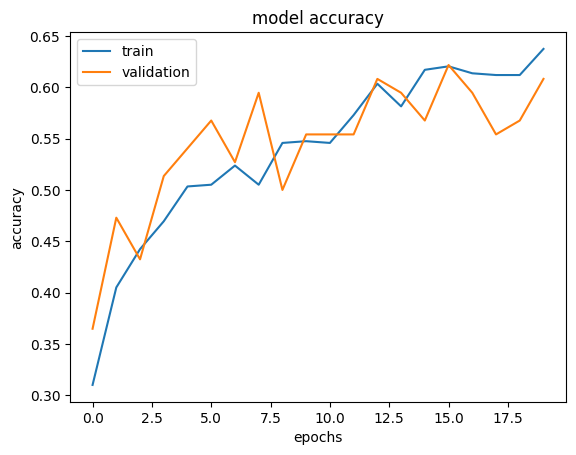

In [14]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes  # True labels

cm = confusion_matrix(y_true, y_pred_classes)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


2/2 [==============================] - 1s 89ms/step


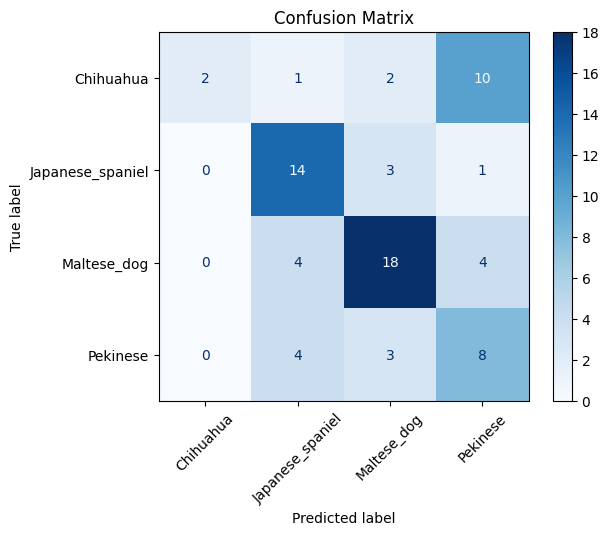

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

# Transfer Learning
Removes core elements of the optmized CNN. Removed layers are left as comments to allow for experimentation with different combinations. 

In [17]:
# Load the VGG16 model
base_model = VGG16(
    weights = 'imagenet', 
    input_shape = (image_size, image_size, image_channel),
    include_top=False)

#freezing the base model
base_model.trainable = False


In [18]:
model = Sequential()

model.add(base_model)

# Input Layer
model.add(Conv2D(32,(3,3),activation='leaky_relu',input_shape = (image_size,image_size,image_channel))) 

model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=64, kernel_size=2, activation='leaky_relu'))
model.add(Dropout(0.2))

# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='leaky_relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# model.add(Conv2D(filters=256 , kernel_size=2 , padding='same' , activation='leaky_relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(num_classes,activation='softmax')) # Softmax for binary classification

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 32)          147488    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                      

In [19]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
train_generator.target_size

(255, 255)

In [21]:
%%time
fitted = model.fit(train_generator,
                    validation_data = val_generator, 
                    epochs = 20,
                    steps_per_epoch = len(train_generator),
                    validation_steps = len(val_generator),
                   )

Epoch 1/20
10/10 [==============================] - 39s 4s/step - loss: 10.0668 - accuracy: 0.2644 - val_loss: 9.6480 - val_accuracy: 0.4595
Epoch 2/20
10/10 [==============================] - 38s 4s/step - loss: 9.6518 - accuracy: 0.3475 - val_loss: 9.3683 - val_accuracy: 0.4865
Epoch 3/20
10/10 [==============================] - 38s 4s/step - loss: 9.3063 - accuracy: 0.5085 - val_loss: 9.1221 - val_accuracy: 0.6622
Epoch 4/20
10/10 [==============================] - 38s 4s/step - loss: 9.1054 - accuracy: 0.5305 - val_loss: 8.9207 - val_accuracy: 0.6892
Epoch 5/20
10/10 [==============================] - 38s 4s/step - loss: 8.8647 - accuracy: 0.5847 - val_loss: 8.6695 - val_accuracy: 0.7162
Epoch 6/20
10/10 [==============================] - 38s 4s/step - loss: 8.6624 - accuracy: 0.6322 - val_loss: 8.4517 - val_accuracy: 0.7703
Epoch 7/20
10/10 [==============================] - 38s 4s/step - loss: 8.3937 - accuracy: 0.7203 - val_loss: 8.2445 - val_accuracy: 0.7838
Epoch 8/20
10/10 [=

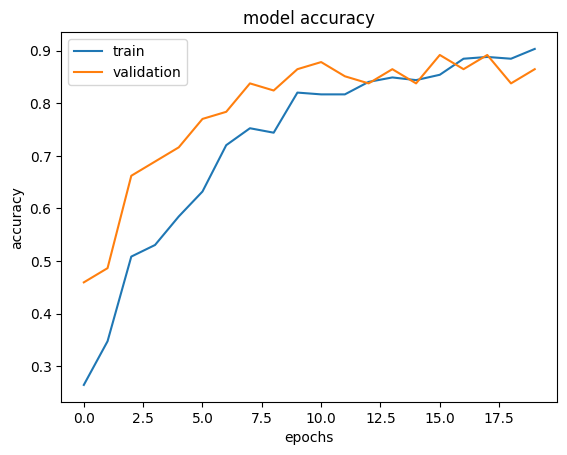

In [22]:
history = model.history

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
# Fine-tuning: Unfreeze some layers
for layer in base_model.layers[-5:]:  # Unfreeze the last 5 layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data = val_generator, 
    epochs = 20,
    steps_per_epoch = len(train_generator),
    validation_steps = len(val_generator),
)

Epoch 1/20
10/10 [==============================] - 39s 4s/step - loss: 6.2167 - accuracy: 0.8898 - val_loss: 6.2660 - val_accuracy: 0.8514
Epoch 2/20
10/10 [==============================] - 38s 4s/step - loss: 6.1999 - accuracy: 0.8932 - val_loss: 6.2580 - val_accuracy: 0.8514
Epoch 3/20
10/10 [==============================] - 38s 4s/step - loss: 6.1452 - accuracy: 0.9237 - val_loss: 6.2273 - val_accuracy: 0.8378
Epoch 4/20
10/10 [==============================] - 38s 4s/step - loss: 6.1621 - accuracy: 0.9000 - val_loss: 6.1931 - val_accuracy: 0.8514
Epoch 5/20
10/10 [==============================] - 38s 4s/step - loss: 6.1502 - accuracy: 0.8983 - val_loss: 6.2001 - val_accuracy: 0.8514
Epoch 6/20
10/10 [==============================] - 38s 4s/step - loss: 6.1139 - accuracy: 0.9220 - val_loss: 6.1905 - val_accuracy: 0.8919
Epoch 7/20
10/10 [==============================] - 38s 4s/step - loss: 6.1314 - accuracy: 0.8831 - val_loss: 6.1840 - val_accuracy: 0.8649
Epoch 8/20
10/10 [==

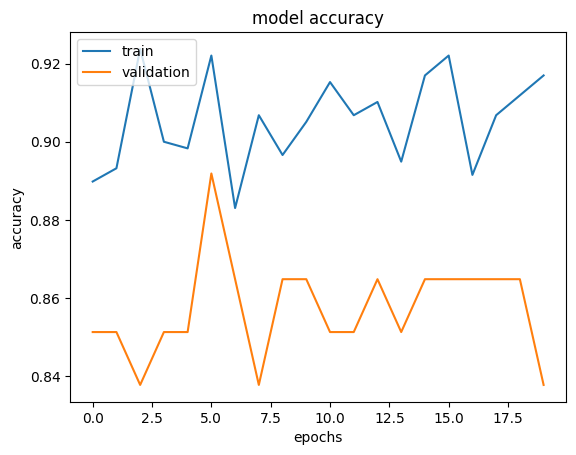

In [24]:
history = model.history

plt.plot(history_fine.history["accuracy"])
plt.plot(history_fine.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes  # True labels

cm = confusion_matrix(y_true, y_pred_classes)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


2/2 [==============================] - 5s 561ms/step


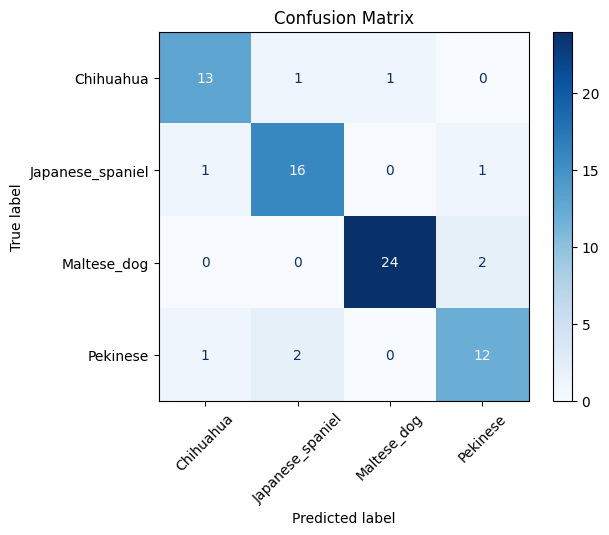

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

# Using Classical Machine Learning
We will be using KMeans in order to try to classify the dog breeds. The performance is significantly worse than the CNN and the CNN with transfer learning. 

For future work, we should look at the bar graph attached below and attempt to get the best accuracies on the least well classified breeds when improving models. 

![image](bar_graph_full.png)

In [27]:
def extract_images(generator):
    images = []
    labels = []
    for i, (image_batch, label_batch) in enumerate(generator):
        images.append(image_batch)
        labels.append(label_batch)
        if len(images) >= generator.samples:
            break
    images = np.vstack(images)
    labels = np.vstack(labels)
    return images, labels 

In [28]:
X_images, y_labels = extract_images(train_generator) 

X_flattened = X_images.reshape(X_images.shape[0], -1)

In [29]:
kmeans = KMeans(n_clusters=num_classes, random_state=42) 
kmeans.fit(X_flattened)

KMeans(n_clusters=4, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8830538..1.0746944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9113199..0.73501885].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8096707..0.76048833].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7431584..1.0711007].


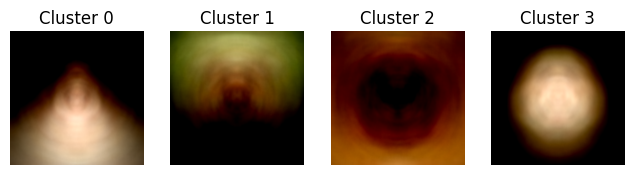

In [34]:
cluster_centers_reshaped = kmeans.cluster_centers_.reshape(num_classes, image_size, image_size, 3)
plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.subplot(2, 5, i+1)
    plt.imshow(cluster_centers_reshaped[i])
    plt.title(f"Cluster {i}")
    plt.axis('off')
plt.show()

In [35]:
y_pred_train = kmeans.predict(X_flattened)
ari_train = adjusted_rand_score(np.argmax(y_labels, axis=1), y_pred_train)

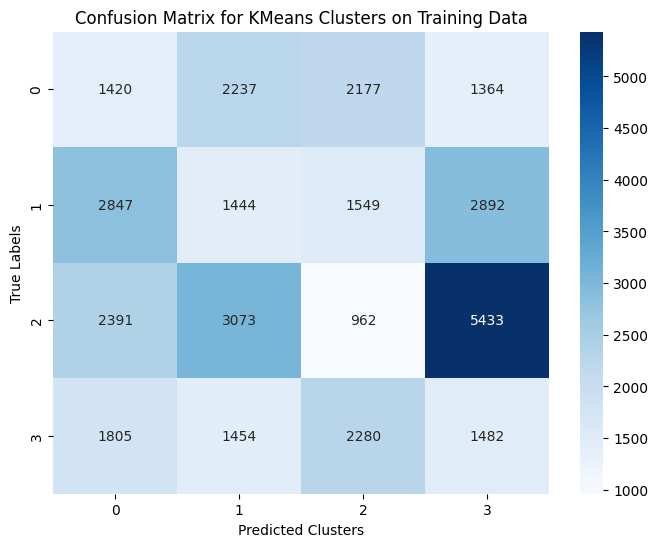

In [36]:
conf_matrix_train = confusion_matrix(np.argmax(y_labels, axis=1), y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix for KMeans Clusters on Training Data')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Labels')
plt.show()

In [ ]:
X_test_images, y_test_labels = extract_images(test_generator)

X_test_flattened = X_test_images.reshape(X_test_images.shape[0], -1)

y_pred_test = kmeans.predict(X_test_flattened)

ari_test = adjusted_rand_score(np.argmax(y_test_labels, axis=1), y_pred_test)

print(f"Adjusted Rand Index (ARI) on the test data: {ari_test:.4f}")

In [ ]:
conf_matrix_test = confusion_matrix(np.argmax(y_test_labels, axis=1), y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix for KMeans Clusters on Test Data')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Labels')
plt.show()

In [ ]:
y_pred_test = kmeans.predict(X_test_flattened)

conf_matrix = confusion_matrix(np.argmax(y_test_labels, axis=1), y_pred_test)

cluster_to_label_mapping = np.argmax(conf_matrix, axis=1)


y_pred_mapped = np.array([None if cluster >= len(cluster_to_label_mapping) else cluster_to_label_mapping[cluster] for cluster in y_pred_test])

accuracy = np.mean(y_pred_mapped == np.argmax(y_test_labels, axis=1))

print(f"Accuracy of KMeans clustering: {accuracy:.4f}")

# Conclusion
The transfer learning with CNN performs the best among the three models that were experimented with. Future work would further experiment with SGD's parameters to find the best values for the optmized model. Reducing training time will also be goal of future work. This can be achieved by things like converting this to a python file that can be executed as a batch job instead. 